In [ ]:
!wget "https://storage.googleapis.com/cae_covid_classification/pretrain.zip"

--2021-07-28 12:05:50--  https://storage.googleapis.com/cae_covid_classification/pretrain.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 142.250.188.48, 142.251.45.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3363344173 (3.1G) [application/x-zip-compressed]
Saving to: ‘pretrain.zip’

pretrain.zip        100%[===================>]   3.13G  54.8MB/s    in 52s     

2021-07-28 12:06:42 (62.2 MB/s) - ‘pretrain.zip’ saved [3363344173/3363344173]



In [ ]:
import tensorflow as tf
import numpy as np
import zipfile
import matplotlib.pyplot as plt

In [ ]:
local = './pretrain.zip'
ref = zipfile.ZipFile(local, mode='r')
ref.extractall(path='./CAE')
ref.close()

In [ ]:
list_ds = tf.data.Dataset.list_files(str('./CAE/pretrain/*.jpeg'))

In [ ]:
len(list_ds)

18617

In [ ]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):

  image = tf.io.read_file(filename)
  image = tf.image.decode_image(image, 3, expand_animations=False)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, 224, 224)
  return image, image

In [ ]:
file_path = next(iter(list_ds))
image_i, image_o = parse_image(file_path)
# values should be in `[0,1]`.
print(np.min(image_i), np.max(image_i))

0.0 1.0


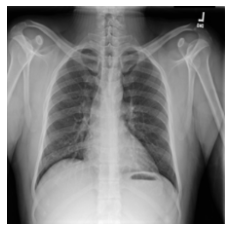

In [ ]:
file_path = next(iter(list_ds))
image_i, image_o = parse_image(file_path)

def show(image):
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

show(image_i)

In [ ]:
images_ds = list_ds.map(parse_image)

(224, 224, 3)
(224, 224, 3)


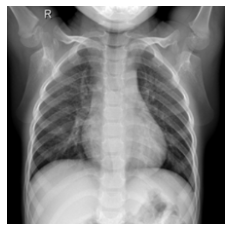

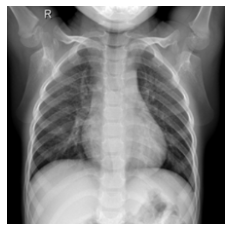

In [ ]:
for image, image_o in images_ds.take(1):
  print(image.shape)
  print(image_o.shape)
  show(image)
  show(image_o)

In [ ]:
val_dataset = images_ds.take(3617)
train_dataset = images_ds.skip(3617)

In [ ]:
len(train_dataset), len(val_dataset)

(15000, 3617)

In [ ]:
train_dataset = train_dataset.batch(64)
val_dataset = val_dataset.batch(64)

In [ ]:
tf.keras.backend.clear_session()
encoder = tf.keras.models.Sequential(name = 'ENCODER', layers=[
                                      tf.keras.layers.InputLayer(input_shape=(224,224,3)),
                                      tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
                                      tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2),
                                      tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2),
                                      tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2),
                                      tf.keras.layers.Conv2D(512, kernel_size=3, padding='same', activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2),
                                      tf.keras.layers.Conv2D(512, kernel_size=3, padding='same', activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2)
])

decoder = tf.keras.models.Sequential(name = 'DECODER', layers=[
                                      tf.keras.layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same', activation='relu'),
                                      tf.keras.layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='relu'),
                                      tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
                                      tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
                                      tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding='same')

])

In [ ]:
cae_model = tf.keras.models.Sequential([encoder, decoder], name='Convolutional_Auto_Encoder')
cae_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [ ]:
checkpoint_cb_cae = tf.keras.callbacks.ModelCheckpoint('cae.h5', save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=1, mode='auto')

In [ ]:
cae_history = cae_model.fit(train_dataset, epochs=100, validation_data=(val_dataset), callbacks=[es, checkpoint_cb_cae])

Epoch 1/100
235/235 [==============================] - 377s 1s/step - loss: 0.0386 - val_loss: 0.0043
Epoch 2/100
235/235 [==============================] - 331s 1s/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/100
235/235 [==============================] - 323s 1s/step - loss: 0.0029 - val_loss: 0.0024
Epoch 4/100
235/235 [==============================] - 321s 1s/step - loss: 0.0024 - val_loss: 0.0026
Epoch 5/100
235/235 [==============================] - 325s 1s/step - loss: 0.0024 - val_loss: 0.0021
Epoch 6/100
235/235 [==============================] - 320s 1s/step - loss: 0.0023 - val_loss: 0.0018
Epoch 7/100
235/235 [==============================] - 325s 1s/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/100
235/235 [==============================] - 331s 1s/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/100
235/235 [==============================] - 333s 1s/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/100
235/235 [==============================] - 323s 1s/step - loss: 0.001

In [ ]:
cae_model.summary()

Model: "Convolutional_Auto_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ENCODER (Sequential)         (None, 7, 7, 512)         3947712   
_________________________________________________________________
DECODER (Sequential)         (None, 224, 224, 3)       3910275   
Total params: 7,857,987
Trainable params: 7,857,987
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoder.summary()

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 256)       0   

In [ ]:
decoder.summary()

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 512)       2359808   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 256)       1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 112, 112, 64)      73792     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 224, 224, 3)       1731      
Total params: 3,910,275
Trainable params: 3,910,275
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoder.save('encoder.h5')

In [ ]:
cae_model = tf.keras.models.load_model('cae.h5')

In [ ]:
test1 = images_ds.take(1)

In [ ]:
for i,_ in test1:
  enc_imgs1 = encoder(i.numpy().reshape((1,224,224,3))).numpy()
  dec_imgs1 = decoder(enc_imgs1).numpy()

In [ ]:
# enc_imgs1 = encoder(train_x[1].reshape((1,224,224,3))).numpy()
# dec_imgs1 = decoder(enc_imgs1).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


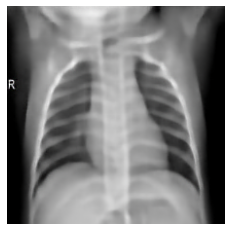

In [ ]:
fig_en = plt.figure(figsize=(20, 4))
plt.imshow(tf.squeeze(dec_imgs1))
plt.axis('off')
plt.grid(False)

In [ ]:
fig_en.savefig('reconstructed_sample1.png', dpi=300)

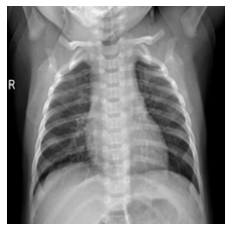

In [ ]:
fig_dec = plt.figure(figsize=(20, 4))
plt.imshow(tf.squeeze(i))
plt.axis('off')
plt.grid(False)

In [ ]:
fig_dec.savefig('actual_sample1.png')

In [ ]:
test2 = images_ds.take(2)
for j,_ in test2:
  enc_imgs2 = encoder(j.numpy().reshape((1,224,224,3))).numpy()
  dec_imgs2 = decoder(enc_imgs2).numpy()

In [ ]:
# enc_imgs2 = encoder(val_x[1].reshape((1,224,224,3))).numpy()
# dec_imgs2 = decoder(enc_imgs2).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


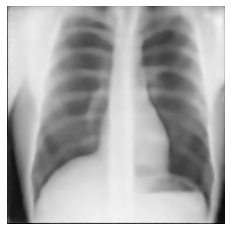

In [ ]:
fig_en1 = plt.figure(figsize=(20, 4))
plt.imshow(tf.squeeze(dec_imgs2))
plt.axis('off')
plt.grid(False)

In [ ]:
fig_en1.savefig('reconstructed_sample2.png', dpi=300)

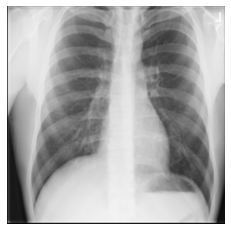

In [ ]:
fig_dec1 = plt.figure(figsize=(20, 4))
plt.imshow(tf.squeeze(j))
plt.axis('off')
plt.grid(False)

In [ ]:
fig_dec1.savefig('actual_sample2.png')

In [ ]:
successive_enc_layers_out = [layer.output for layer in encoder.layers]

vis_model = tf.keras.models.Model(inputs=encoder.input, outputs=successive_enc_layers_out)
random_img = random.choice(cae_images)
random_img = random_img.reshape((1,)+random_img.shape)
successive_feature_maps = vis_model.predict(random_img)
enc_layer_names = [layer.name for layer in encoder.layers]

for lay_name, feature_map in zip(enc_layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size*n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i*size : (i+1)*size] = x
    scale = 30. / n_features
    fig_enc_rep = plt.figure(figsize=(scale*n_features, scale))
    plt.title(lay_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    fig_enc_rep.savefig(lay_name+'.png', dpi=1200)